ELO rating of Magnus Carlsen normalized between 0 and 1:
1.0308641975308641
ELO ratings normalized between 0 and 1:
[0.94500561 0.95173962 0.93602694 0.97530864 0.9382716  1.
 0.996633   0.9298541  0.92199776 0.88215488 0.95735129 0.9640853
 0.98092031 0.96632997 0.96184063 0.91975309 0.91189675 0.96632997
 0.94949495 0.94388328 0.92031425 0.9315376  0.92648709 0.87429854
 0.98597082 0.93265993 0.89786756 0.75308642 0.93434343 0.90909091
 0.91638608 0.98035915 0.97418631 0.835578   0.94332211 0.93209877
 0.84904602 0.90796857 0.89955107 0.80920314 0.88496072 0.7687991
 0.97025814 0.81874299 0.92592593 0.91077441 0.88439955 0.85802469
 0.83838384 0.86026936 0.86195286 0.88776655 0.90179574 0.87991021
 0.89113356 0.80583614 0.82716049 0.98148148 0.82716049 0.87093154
 0.81818182 0.82659933 0.69304153 0.63468013 0.78900112 0.80246914
 0.89842873 0.80527497 0.73176207 0.80920314 0.74859708 0.74074074
 0.79854097 0.69640853 0.75925926 0.74579125 0.78451178 0.68350168
 0.94949495 0.80415264 

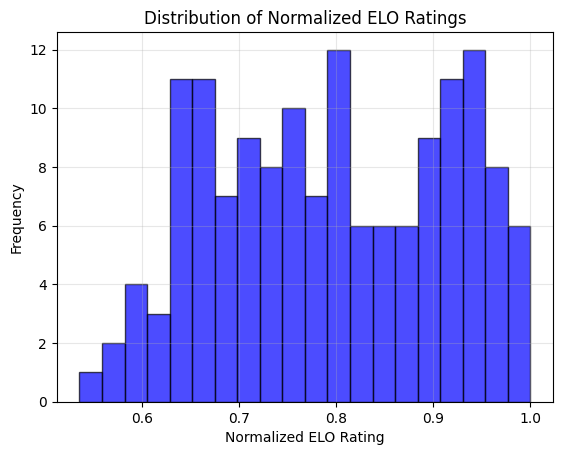

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("chessResultsList.xlsx")

# Mise à part de la première ligne (Magnus Carlsen)
first_row = df.iloc[0].copy()
df = df.drop(index=0)

elos = df["Rtg"].values

# Affichage de l'ELO du premier joueur normalisé
print("ELO rating of Magnus Carlsen normalized between 0 and 1:")
elo = first_row["Rtg"]
elo = (elo-1000) / (elos.max()-1000)
print(elo)

# Normalisation des ELOs entre 0 et 1
elos = (elos - 1000) / (elos.max() - 1000)

print("ELO ratings normalized between 0 and 1:")
print(elos)

# Affichage de l'histogramme
plt.hist(elos, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Normalized ELO Ratings')
plt.xlabel('Normalized ELO Rating')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Estimation du paramètre α

Pour une distribution avec une répartition de queue $\ \pi (1-u) ~  C * u^{α}$, on peut estimer α à l'aide d'une régression linéaire.

En effet, si on prend le logarithme de la répartition de queue, on obtient une relation linéaire entre log(π(1-u)) et log(u) :

$$log( \pi (1-u)) = log(C) - α * log(u)$$

Estimated α: 1.2440
Estimated C: 4.4120
R-squared: 0.9671


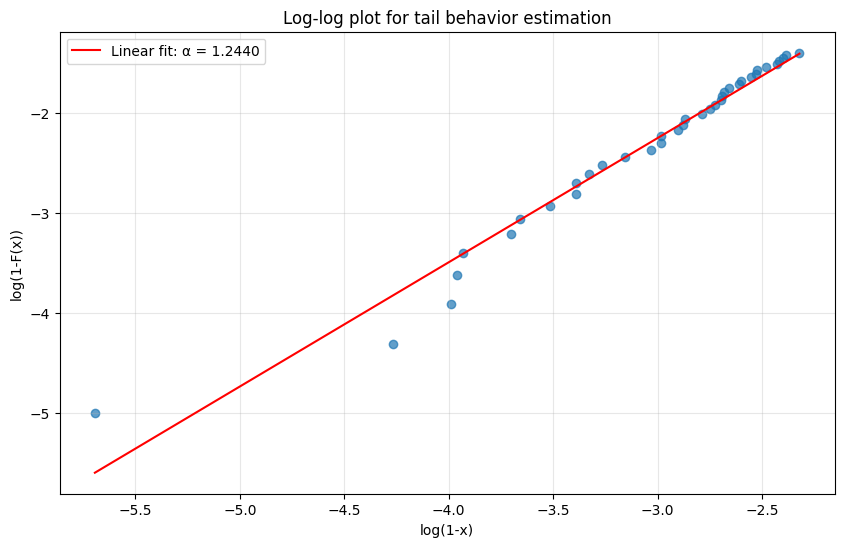

In [7]:
import numpy as np
from scipy import stats

sorted_elos = np.sort(elos)

# Creation de la fonction de répartition empirique
n = len(sorted_elos)
ecdf = np.arange(1, n + 1) / n

# On se concentre sur la queue supérieure de la distribution
# On choisit un seuil de 0.75 pour se concentrer sur le 25% supérieur des valeurs
threshold = 0.75
tail_indices = sorted_elos >= np.quantile(sorted_elos, threshold)

tail_elos = sorted_elos[tail_indices]
tail_ecdf = ecdf[tail_indices]

# Calcul de la fonction de survie
survival = 1 - tail_ecdf

# Calcul de la distance à la valeur maximale
distance_from_max = 1 - tail_elos

# Filtrage des valeurs pour éviter les problèmes de log(0)
valid_indices = (distance_from_max > 0) & (survival > 0)
log_distance = np.log(distance_from_max[valid_indices])
log_survival = np.log(survival[valid_indices])

# Estimation de la relation log-log
slope, intercept, r_value, p_value, std_err = stats.linregress(log_distance, log_survival)

# Affichage des résultats
alpha = slope
C = np.exp(intercept)

print(f"Estimated α: {alpha:.4f}")
print(f"Estimated C: {C:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Plot the log-log relationship
plt.figure(figsize=(10, 6))
plt.scatter(log_distance, log_survival, alpha=0.7)
plt.plot(log_distance, intercept + slope * log_distance, 'r-', 
         label=f'Linear fit: α = {alpha:.4f}')
plt.title('Log-log plot for tail behavior estimation')
plt.xlabel('log(1-x)')
plt.ylabel('log(1-F(x))')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Verification des conditions du théorème

Théorème:

- Soit $\  \sigma^{2}= E[  \frac {θ}{1+θ^{2}}  ] $ la variance du meilleur joueur.
- Soit $\ ε_n$ = $\ \sqrt{ \frac{2- \alpha } {\sigma^{2}} * \frac {log(n)}{n} } $

Alors:
- Si lim inf $\ [ \frac{θ*n - 1}{ε_n} ]$> 1, then P(s* wins) → 1
- Si lim sup $\ [ \frac{θ*n - 1}{ε_n} ]$< 1, then P(s* wins) → 0

Où $\ θ*n $ représente la force du "super" joueur, et $\ ε_n $ est un seuil qui détermine la probabilité de victoire.

In [13]:
# Vérification de la condition α < 2
print(f"Is α < 2? {alpha < 2}")

# Calcul de σ² = E[θ/(1+θ)²]
def variance_term(theta):
    return theta / ((1 + theta) ** 2)

sigma_squared = np.mean(variance_term(sorted_elos))
print(f"σ² = {sigma_squared:.6f}")

# Calcul de ε_n: ε_n = √((2-α)/σ²) * √(log(n)/n)
epsilon_n = np.sqrt((2 - alpha) / sigma_squared) * np.sqrt(np.log(n) / n)
print(f" = {epsilon_n:.6f}")

# Calcul de (θ*_n - 1)/ε_n
theta_star_n = elo  # puissance de Magnus Carlsen
threshold_ratio = (theta_star_n - 1) / epsilon_n
print(f"θ*_n = {theta_star_n:.6f}")
print(f"(θ*_n - 1)/ε_n = {threshold_ratio:.6f}")

# Interprétation du résultat
if threshold_ratio > 1:
    print("\nAccording to the theorem, P(s* wins) → 1")
    print("This suggests that the best player (Magnus Carlsen) will win with high probability.")
else:
    print("\nAccording to the theorem, P(s* wins) → 0")
    print("This suggests that even the best player (Magnus Carlsen) will not consistently win.")

Is α < 2? True
σ² = 0.245033
 = 0.321883
θ*_n = 1.030864
(θ*_n - 1)/ε_n = 0.095886

According to the theorem, P(s* wins) → 0
This suggests that even the best player (Magnus Carlsen) will not consistently win.
